CPU/GPU 문제가 아니라, 버전에 따라서 연산 방법 자체가 달라진 듯 하다.

1.7.1 cuda 11.0 버전에서 테스트 해야함(설치된 cuda toolkit은 11.2)

In [1]:
%load_ext lab_black
%cd ..

/home/shim/shim/dev/log-analytics


In [2]:
import argparse
import math
import multiprocessing
import sys
from datetime import datetime
from pathlib import Path
from pprint import pformat

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_optimizer
import yaml
from easydict import EasyDict
from pytorch_transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    DistilBertForSequenceClassification,
    DistilBertTokenizer,
    RobertaForSequenceClassification,
    RobertaTokenizer,
)
from sklearn.model_selection import StratifiedKFold
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import (
    AlbertForSequenceClassification,
    AlbertTokenizer,
    DebertaForSequenceClassification,
    DebertaTokenizer,
    SqueezeBertTokenizer,
    SqueezeBertForSequenceClassification,
    XLNetTokenizer,
    XLNetForSequenceClassification,
)

from datasets import load_test_data, load_train_data
from utils import SAM, AverageMeter, CustomLogger, FocalLoss, seed_everything

from main import MyTrainer
from collections import defaultdict
import matplotlib.pyplot as plt

In [3]:
with open("config/deberta-base.yaml", "r") as f:
    C = EasyDict(yaml.load(f, yaml.FullLoader))
    C.result_dir = Path(C.result_dir)
    C.dataset.dir = Path(C.dataset.dir)
    seed_everything(C.seed, deterministic=False)

In [5]:
C.dataset.batch_size = 25

In [6]:
C

{'model': {'name': 'microsoft/deberta-base'},
 'comment': None,
 'result_dir': PosixPath('results/deberta-base'),
 'debug': False,
 'seed': 20210425,
 'train': {'SAM': False,
  'folds': [1],
  'checkpoints': [None],
  'loss': {'name': 'focal', 'gamma': 2},
  'optimizer': {'name': 'AdamW'},
  'finetune': {'do': True, 'step1_epochs': 2, 'step2_epochs': 4},
  'max_epochs': 12,
  'lr': 1e-05,
  'scheduler': {'name': 'ReduceLROnPlateau',
   'params': {'factor': 0.5, 'patience': 3, 'verbose': True}}},
 'dataset': {'dir': PosixPath('data/ori'), 'batch_size': 25, 'num_workers': 8}}

In [7]:
trainer = MyTrainer(C, 1, "results/deberta-base/deberta-base-focal-AdamW-lr1e-05_1.pth")

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.weight

Load pretrained results/deberta-base/deberta-base-focal-AdamW-lr1e-05_1.pth


In [8]:
model = trainer.model
model.eval()
torch.set_grad_enabled(False)

In [9]:
ds = trainer.dl_test.dataset
ds2 = trainer.dl_test2.dataset
tds = trainer.tdl.dataset
vds = trainer.vdl.dataset

In [10]:
# id, text, otext = ds2[2]
# print(id)
id, text, level, otext = vds[2111]
print(id, level)
print(otext)

r = model(text[None].cuda())[0].softmax(1)[0].cpu()
print(r, r.argmax())

10474 tensor(0)
logstash: [2020-12-28T10:53:35,263][ERROR][logstash.outputs.elasticsearch] Attempted to send a bulk request to elasticsearch, but no there are no living connections in the connection pool. Perhaps Elasticsearch is unreachable or down? {:error_message=>"No Available connections", :class=>"LogStash::Outputs::ElasticSearch::HttpClient::Pool::NoConnectionAvailableError", :will_retry_in_seconds=>64}
tensor([9.9159e-01, 2.4096e-05, 1.5177e-04, 8.0434e-03, 1.3728e-05, 1.5336e-04,
        2.3088e-05]) tensor(0)


### 각각의 level마다 confidence를 측정

In [13]:
leveldic = defaultdict(list)
confidencedic = defaultdict(list)
allconfdic = defaultdict(list)
wrongdic = defaultdict(list)
with tqdm(total=len(vds), ncols=100, file=sys.stdout) as t:
    for i, (id, text, tlevel, otext) in enumerate(vds):
        pred = model(text[None].cuda())[0].softmax(1)[0].cpu()
        confidence, plevel = pred.max(0)
        if plevel == tlevel:
            confidencedic[tlevel.item()].append(confidence.item())
        else:
            # wrong.append((i, tlevel.item()))
            wrongdic[tlevel.item()].append(
                {
                    "id": i,
                    "otext": otext,
                    "pconf": confidence.item(),
                    "plevel": plevel.item(),
                    "tconf": pred[tlevel.item()].item(),
                    "tlevel": tlevel.item(),
                }
            )

        allconfdic[tlevel.item()].append(i)
        leveldic[tlevel.item()].append(i)

        t.update()

100%|█████████████████████████████████████████████████████████| 94595/94595 [23:19<00:00, 67.58it/s]


In [29]:
data = np.load("results/deberta-base/deberta-base-focal-AdamW-lr1e-05_1-valid.npz", allow_pickle=True)

In [40]:
leveldic = data["leveldic"].item()
confidencedic = data["confidencedic"].item()
allconfdic = data["allconfdic"].item()
wrongdic = data["wrongdic"].item()

In [43]:
wrongdic[1]

[{'id': 1745,
  'otext': 'level : 5, log : Ignoring RADIUS server radius-server: unable to bind to source address source-address (error-message)',
  'pconf': 0.6731650829315186,
  'plevel': 0,
  'tconf': 0.3150128722190857,
  'tlevel': 1},
 {'id': 2016,
  'otext': 'level : 5, log : function-name operation failed for object-name: index1 index1 index2 index2 index3 index3 index4 index4 (error-message)',
  'pconf': 0.6704509258270264,
  'plevel': 0,
  'tconf': 0.3168269991874695,
  'tlevel': 1},
 {'id': 2438,
  'otext': 'level : 3, log : Client aborted login',
  'pconf': 0.6745659112930298,
  'plevel': 0,
  'tconf': 0.31370052695274353,
  'tlevel': 1},
 {'id': 2937,
  'otext': 'level : 5, log : Versions of BFD mirror software on Routing Engines are incompatible: error-message',
  'pconf': 0.6726464629173279,
  'plevel': 0,
  'tconf': 0.3151087760925293,
  'tlevel': 1},
 {'id': 3339,
  'otext': 'level : 3, log : function-name: runtime was excessive (time) during action of module',
  'pconf

In [14]:
sorted(confidencedic.keys())

[0, 1, 2, 3, 5, 6]

ValueError: min() arg is an empty sequence

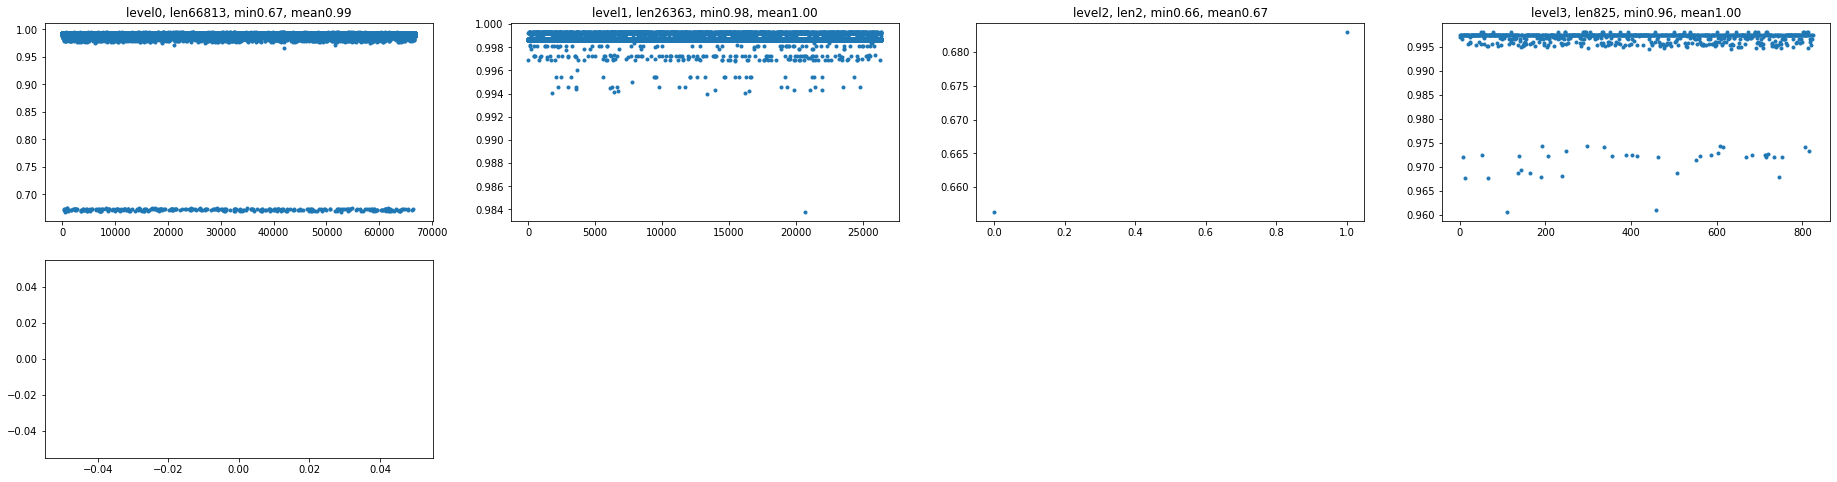

In [17]:
plt.figure(figsize=(32, 8))
for level in range(7):
    plt.subplot(2, 4, level + 1)
    plt.plot(confidencedic[level], ".")
    plt.title(
        f"level{level}, len{len(confidencedic[level])}, min{min(confidencedic[level]):.2f}, mean{sum(confidencedic[level]) / len(confidencedic[level]):.2f}"
    )
plt.tight_layout()
plt.show()

1

In [18]:
np.savez_compressed(
    "results/deberta-base/deberta-base-focal-AdamW-lr1e-05_1-valid.npz",
    leveldic=leveldic,
    confidencedic=confidencedic,
    allconfdic=allconfdic,
    wrongdic=wrongdic,
)

In [19]:
for ids, texts, otexts in trainer.dl_test2:
    break

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/shim/anaconda3/envs/shim/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 202, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/shim/anaconda3/envs/shim/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/shim/anaconda3/envs/shim/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/shim/shim/dev/log-analytics/datasets.py", line 102, in __getitem__
    text = remove_date(text)
  File "/home/shim/shim/dev/log-analytics/datasets.py", line 49, in remove_date
    t = first_word(full_log)
  File "/home/shim/shim/dev/log-analytics/datasets.py", line 35, in first_word
    for i, t in enumerate(text):
TypeError: 'int' object is not iterable


## Submission

그냥 fold1 deberta로 submission(level 7은 무시)을 만들면 어느정도 정확도가 나올까?

In [11]:
preds = []
with tqdm(total=len(trainer.dl_test.dataset), ncols=100, file=sys.stdout) as t:
    for id, text, otext in trainer.dl_test:
        pred = model(text.cuda())[0].softmax(1).cpu()
        preds.append(pred)
        # break
        t.update(len(id))

100%|███████████████████████████████████████████████████| 1418916/1418916 [4:04:30<00:00, 96.72it/s]


In [14]:
preds[0].shape

torch.Size([25, 7])

In [15]:
ps = torch.cat(preds, dim=0)

In [16]:
ps.shape

torch.Size([1418916, 7])

In [17]:
plevel = ps.argmax(dim=1)

In [18]:
plevel.shape

torch.Size([1418916])

In [19]:
j = 1000
plevel[j : j + 100]

tensor([0, 0, 0, 1, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 1, 0, 0])

In [20]:
data = {"id": list(range(1000000, 2418915 + 1)), "level": plevel.tolist()}

In [21]:
df = pd.DataFrame(data)

In [22]:
df

,id,level
0,1000000,0
1,1000001,0
2,1000002,1
3,1000003,0
4,1000004,1
...,...,...
1418911,2418911,0
1418912,2418912,0
1418913,2418913,1
1418914,2418914,0


In [23]:
for i in range(7):
    print((plevel == i).sum().item())

1004280
395168
34
12948
18
6459
9


In [24]:
df.to_csv("results/deberta-base/deberta-base-focal-AdamW-lr1e-05_1.csv", index=False)

In [25]:
ps_np = ps.numpy()

In [26]:
np.savez_compressed("results/deberta-base/deberta-base-focal-AdamW-lr1e-05_1-test.npz", ps=ps_np)

## 정확도

### 그냥 정확도

In [58]:
cnt = 0
for i in range(7):
    cnt += len(wrongdic[i])

In [63]:
vacc = 1 - cnt / len(vds)

In [64]:
vacc

0.998202864844865

### 1인데 1의 confidence랑 0의 confidence의 차가 0.5 이하면 0이라고 했을 때 정확도는?

In [71]:
d = wrongdic[1][4]
abs(d["pconf"] - d["tconf"])

0.10417789220809937

### MEMO

level 0, 1은 99% 정도의 높은 confidence를 보이는 반면, level 2는 validation에도 2개의 데이터밖에 없기 때문에 65%의 confidence가 나온다.

valid idx 68298, 75845

- level별로 confidence threshold가 천차만별일 듯 하다.  
- level별로 validation을 진행하고 confidence의 목록을 만들어서 확인해보자!!

### 결과 만들기

- 0이랑 1 사이에서 고문하는 경우도 --> |conf[0] - conf[1]| < 0.1 일 경우  
1을 0으로 착각한건 20개, 0을 1로 착간한건 132개. 그러므로 위의 경우에는 0으로 결정하는게 좋겠다.

- fold1에서 2~6까지는 틀린게 하나도 없었음. (물론 데이터 수도 적었지만)

### 정책

- 